In [1]:
%load_ext autoreload
%autoreload 2
#%matplotlib notebook
%matplotlib inline

In [2]:
import argparse
import functools
import hashlib
import itertools
import json
import os
import sys
from copy import deepcopy
from functools import partial, reduce
from glob import glob
from multiprocessing import Pool
from time import sleep

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import portalocker as pl
import seaborn as sns
from matplotlib import cm
from tqdm import tqdm
from matplotlib.lines import Line2D
from copy import deepcopy
from plot_metrics import preprocess_metrics
from matplotlib.ticker import LogLocator
import matplotlib.patches as mpatches
from util.metrics_utils import *
from util.colour_mapper import colour_mapper
import warnings
warnings.filterwarnings('ignore')

In [ ]:
#UTILS

In [3]:
def clean_results(_df_tr, df_tr, _df_ti):    
    appr_list = ['joint', 'backbonefreezing' ]
    t = _df_tr[~((_df_tr['Approach'].isin(appr_list)) & (_df_tr['Memory Size'] != 1000))]
    _df_tr = deepcopy(t)

    t = df_tr[~((df_tr['Approach'].isin(appr_list)) & (df_tr['Memory Size'] != 1000))]
    df_tr = deepcopy(t)    
    
    t = _df_ti[~((_df_ti['Approach'].isin(appr_list)) & (_df_ti['Memory Size'] != 1000))]
    _df_ti = deepcopy(t) 

    t = df_tr[~((df_tr['Approach']=='scratch') & (df_tr['Memory Size'] !=0))]
    df_tr = deepcopy(t)

    t = df_tr[~((df_tr['Approach']=='bic') & (df_tr['Memory Size'] != 1000))]
    df_tr = deepcopy(t)
    
    return _df_tr, df_tr, _df_ti


#correzione eeil train
def eeil_correction(_df_ti, group):
    _df_tr_eeil = _df_tr[(_df_tr['Approach']=='eeil') & (_df_tr['Task']==1)]
    temp = _df_tr_eeil.groupby(group)['Epoch'].max().reset_index()
    temp_time = _df_tr_eeil.groupby([group])[[group,'Train Time']].head(3).reset_index()
    temp_time = temp_time.groupby(group).mean().reset_index()
    max_epochs_eeil = max_epochs[max_epochs['Approach']=='eeil']
    temp = pd.merge(max_epochs_eeil, temp_time, on=[group])
    temp['Time'] = temp[['Epoch', 'Train Time_y']].apply(lambda x: x[0] * x[1], axis=1)
    for c in temp[group].unique():
        _df_ti.loc[_df_ti[(_df_ti['Approach']=='eeil') & (_df_ti['Type']=='train') & (_df_ti['Task']==1) & (_df_ti[group]==c)].index.values[0], 'Time'] = temp[temp[group]==c]['Time'].values[0]

    return _df_ti

In [4]:
def divided_barplot_settings(ax1,ax2,ymax):
    d = .015  
    kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
    ax1.plot((-d, +d), (-d, +d), **kwargs)        
    ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)  
    kwargs.update(transform=ax2.transAxes)  
    ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  
    ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs) 
    ax1.set_xlabel('')
    ax2.set_xlabel('')
    ax1.spines['bottom'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax1.set(ylabel=None)
    ax2.set(ylabel=None)  
    ax2.xaxis.tick_bottom() 
    ax1.tick_params(bottom=False)  # don't put tick labels at the top
    ax2.tick_params(labeltop=False)  # don't put tick labels at the top

def add_vertical_lines(ax, ymax, ord_list):
    for i,b in enumerate(ax.patches):
        if ord_list[i]=='_': 
            x,y = b.get_xy()
            plt.vlines(x = x+b.get_width()/2, ymin = 0, ymax = ymax, color = 'gray', 
                       linewidth=1.5, linestyle='dashed')
            
def add_vertical_lines_divided(ax1,ax2,ymax,ord_list):
    for i,b in enumerate(ax1.patches):
        if ord_list[i]=='_':
            x,y = b.get_xy()
            x2,y2 = ax2.patches[i].get_xy()
            ax1.vlines(x = x+b.get_width()/2, ymin = 0, ymax = ymax, color = 'gray', 
                           linewidth=1.5, linestyle='dashed')
            ax2.vlines(x = x2+b.get_width()/2, ymin = 0, ymax = ymax, color = 'gray', 
                           linewidth=1.5, linestyle='dashed')

        
def add_vertical_lines_hatches_colors_divided(ax1,ax2,ymax,ord_list,palette):
    '''
    for i,b in enumerate(ax1.patches[:14]):
        if ord_list[i]=='_': 
            x,y = b.get_xy()
            x2,y2 = ax2.patches[i].get_xy()
            ax1.vlines(x = x+b.get_width()/2, ymin = 0, ymax = ymax, color = 'gray', linewidth=1.5)
            ax2.vlines(x = x2+b.get_width()/2, ymin = 0, ymax = ymax, color = 'gray', linewidth=1.5)
    '''
    for i,bar in enumerate (ax1.patches):
        bar.set_facecolor(palette[ord_list[i%12]])
        ax2.patches[i].set_facecolor(palette[ord_list[i%12]])
        if i>=24:
            bar.set(hatch = '////')
            ax2.patches[i].set(hatch = '////')            

def add_vertical_lines_hatches_colors(ax, ymax,ord_list, palette):
    for i,b in enumerate(ax.patches[:len(ord_list)]):
        if ord_list[i]=='_': 
            x,y = b.get_xy()
            ax.vlines(x = x+b.get_width()/2, ymin = 0, ymax = ymax, color = 'gray', 
                    linewidth=1.5)
    for i,bar in enumerate (ax.patches):                
        bar.set_facecolor(palette[ord_list[i%12]])
        if i>=24:
            bar.set(hatch = '////')
            
def plot_train_time(df_ti, type, appr_task, group, nclasses, normalize, figsize=None):
    ord_list = ['lwfgkd','_','jointmem', 'backbonefreezingmem', 'icarlp', 'lucir', 'ssil', '_','bic', 'eeil', 'ewc','icarl', 'il2m','chen2021']
    ord_list = ['lwfgkd','jointmem', 'backbonefreezingmem', 'icarlp', 'lucir', 'ssil','bic', 'eeil', 'ewc','icarl', 'il2m','chen2021']
    ord_list = ['bic', 'eeil', 'ewc', 'jointmem', 'backbonefreezingmem', 'icarl', 'icarlp', 'il2m', 'lucir','lwfgkd', 'chen2021', 'ssil']
    palette = dict([(k, colour_mapper()[k]) for k in ord_list])
    labels = [appr_dict[item] if item!='_' else ' ' for item in ord_list]
    labels = [appr_dict[item] if item!='lwfgkd' else 'LWF' for item in ord_list]
    if type=='all':
        sns.set_style("whitegrid")
        df = df_ti[(df_ti['Task']==appr_task) & (df_ti['Type']!='test')].groupby(['Approach',group])['Time'].sum().reset_index()
        if normalize: df['Time'] = df['Time'].div(nclasses)
        f, (ax1, ax2) = plt.subplots(2, 1, figsize=figsize, sharex=True)
        bars1 = sns.barplot(x='Approach', y='Time' , data=df, ax=ax1, order=ord_list, palette=palette)#, ci='sd')
        bars2 = sns.barplot(x='Approach', y='Time' , data=df, ax=ax2, order=ord_list, palette=palette)#, ci='sd')
        bars1.legend(ax1.patches, [appr_dict[i] for i in ord_list], bbox_to_anchor=(1.05, 1),
                     loc=2, borderaxespad=0.1, ncol=1, fontsize=12, frameon=False)
        ax2.set_ylim(0, 450)
        ax1.set_ylim(1000, 3800)
        if not normalize:
            ax2.set_ylim(0*nclasses, 450*nclasses)  
            ax1.set_ylim(1000*nclasses, 3800*nclasses)
        ax2.set_ylabel('Time [s]')
        ax2.yaxis.set_label_coords(-0.15,1.02)
        ymax = 3800 if normalize else 3800*nclasses
        add_vertical_lines_divided(ax1,ax2,ymax,ord_list)                    
        divided_barplot_settings(ax1,ax2,ymax)
        plt.xticks([])
        sns.reset_defaults()

    elif type=='all_normalized_scratch':
        sns.reset_defaults()
        df = df_ti[(df_ti['Task']==appr_task) & (df_ti['Type']!='test')].groupby(['Approach',group])['Time'].sum().reset_index()
        if normalize: df['Time'] = df['Time'].div(nclasses)
        f, (ax1, ax2) = plt.subplots(2, 1, figsize=figsize, sharex=True)
        for s in df[group].unique():
            df.loc[(df[group]==s),'Time'] = df.loc[(df[group]==s),'Time'].div(df[(df[group]==s) & (df['Approach']=='scratch')]['Time'].values[0])
        df = df[~(df['Approach']=='scratch')]
        describe = df.groupby('Approach')['Time'].describe()[['mean','std']].reset_index()
        describe[describe.Approach.isin(ord_list)].to_csv(type+'_'+str(nclasses)+'.csv')
        if nclasses==20:
            bars1 = sns.barplot(x='Approach', y='Time' , data=df, ax=ax1, order=ord_list, palette=palette)#, ci='sd')
            bars2 = sns.barplot(x='Approach', y='Time' , data=df, ax=ax2, order=ord_list, palette=palette)#, ci='sd')            
            ax1.set_ylim(9.5, 11.5)  
            ax2.set_ylim(0, 1.1)  
            ymax = 20
            divided_barplot_settings(ax1,ax2,ymax)
            add_vertical_lines_divided(ax1,ax2,ymax,ord_list)
            ax1.yaxis.grid(True)
            ax1.set_axisbelow(True)
            ax2.yaxis.grid(True)
            ax2.set_axisbelow(True)
            ax2.set_ylabel('Ratio of Scratch Total Training Time')
            ax2.yaxis.set_label_coords(-0.10,1.02)                                             
            ax2.set_xticklabels(labels)
        else:
            plt.close()
            bars1 = sns.barplot(x='Approach', y='Time' , data=df, ax=ax, order=ord_list, palette=palette)#, ci='sd')
            ax.set_ylim(0, 0.06)
            ax.set_ylabel('Ratio of Scratch Total Training Time')
            ymax=20
            add_vertical_lines(ax, ymax, ord_list)
            ax.set_xticklabels(labels)
            
        plt.xticks(rotation=45)
        ax.set_xlabel('')
        ax.yaxis.grid(True)
        ax.set_axisbelow(True)
        sns.reset_defaults() 

    elif type=='stacked':
        df = df_ti[(df_ti['Task']==appr_task) & (df_ti['Type']!='test') & (df_ti['Approach'].isin(ord_list))]
        df_total = df_ti[(df_ti['Task']==appr_task) & (df_ti['Type']!='test')].groupby(['Approach',group])['Time'].sum().reset_index()
        times={}
        t = ['post_train', 'train', 'pre_train']
        for time_type in t:
            df_temp= df[df['Type']==time_type].reset_index()
            for s in df_temp[group].unique():
                df_temp.loc[(df_temp[group]==s),'Time'] = df_temp.loc[(df_temp[group]==s),'Time'].div(df_total[(df_total[group]==s) & (df_total['Approach']=='scratch')]['Time'].values[0])
            df_temp = df_temp[~(df_temp['Approach']=='scratch')]
            df_temp = df_temp.groupby('Approach')['Time'].mean().reset_index()
            #new_row = {'Approach':'_', 'Time':0}
            #df_temp = df_temp.append(new_row, ignore_index=True)
            #df_temp = df_temp.append(new_row, ignore_index=True)
            times[time_type] = df_temp['Time'].values  

        approach = df_temp['Approach']
        index = [appr_dict[i] for i in approach.values]
        ord_list_new = [appr_dict[i] for i in ord_list]
        df = pd.DataFrame({'Approach':index, 'Pre_Train':times['pre_train'], 'Train':times['train'], 'Post_Train':times['post_train'] })
        ##df = df.set_index('Approach').loc[ord_list_new].reset_index()
        #df = df.drop(labels=[2,9], axis=0).set_index('Approach')
        #print(df)
        ###sum order
        df['sum'] = df['Post_Train'] + df['Train']
        df = df.sort_values(by=['sum'])
        df = df.drop('sum', axis=1)
        inv_appr_dict = {v: k for k, v in appr_dict.items()}
        index_bis = [inv_appr_dict[i] for i in df.Approach.values]
        labels = [item if item!='LwF-GKD' else 'LwF' for item in df.Approach.values]
        palette = dict([(k, colour_mapper()[k]) for k in index_bis])
        ###
        patch1 = mpatches.Patch(color='gainsboro', label='Post-SGD', ec='black',lw=1,hatch='////')
        patch2 = mpatches.Patch(color='gainsboro', label='SGD', ec='black',lw=1)
        handles = [patch1, patch2]
        
        if nclasses==1:
            ax.set_ylabel('Ratio of Scratch Total Training Time', fontsize=13)
            bars = df.plot.bar(stacked=True, ax=ax, alpha=.80, edgecolor='black',width=0.7, legend=True) 
            ymax=0.06
            ax.set_xticklabels(labels, fontsize=11)
            plt.xticks(rotation=45)   
            plt.xlabel('')
            plt.ylim([0,0.06])
            ax.yaxis.grid(True, linestyle='--')
            ax.set_axisbelow(True)
            ax.legend(handles=handles, facecolor='white', ncol=1, frameon=True, handlelength=1.50, columnspacing=5, fontsize=12, handletextpad=0.5, numpoints=1)
            add_vertical_lines_hatches_colors(ax,ymax,index_bis,palette)
        else:
            f, (ax1, ax2) = plt.subplots(2, 1, figsize=figsize, sharex=True)
            ax2.set_ylim(0, 1.1)  
            ax1.set_ylim(9.5, 10.6)
            bars1 = df.plot.bar(stacked=True, ax=ax1, alpha=.80, edgecolor='black',width=0.7, legend=True) 
            bars2 = df.plot.bar(stacked=True, ax=ax2, alpha=.80, edgecolor='black',width=0.7, legend=False)                     
            ax1.yaxis.grid(True, linestyle='--')
            ax1.set_axisbelow(True)
            ax2.yaxis.grid(True, linestyle='--')
            ax2.set_axisbelow(True)
            ymax = 20
            divided_barplot_settings(ax1,ax2,ymax)
            plt.xticks(rotation=45)
            ax.set_xlabel('')
            ax.yaxis.grid(True)
            ax.set_axisbelow(True)
            ax2.set_xticklabels(labels, fontsize=11)
            ax2.set_ylabel('Ratio of Scratch Total Training Time', fontsize=13)
            ax2.yaxis.set_label_coords(-0.12,1.02)
            add_vertical_lines_hatches_colors_divided(ax1,ax2,ymax,index_bis,palette)
            ax1.legend(handles=handles, facecolor='white', ncol=1, frameon=True, handlelength=1.50, columnspacing=5, fontsize=12, handletextpad=0.5, numpoints=1)

        
    elif type=='post_train_percentage':
        dft1 = df_ti[(df_ti['Task']==appr_task) & (df_ti['Type']!='test')]
        df1 = dft1.groupby(['Approach',group])['Time'].sum().reset_index()
        df1['Time'] = df1['Time'].div(nclasses)
        df_all = deepcopy(df1)
        df_all = df_all.sort_values(['Approach', group]).reset_index()
        sns.reset_defaults()
        df1 = df_ti[(df_ti['Task']==appr_task) & (df_ti['Type']=='post_train')]
        df1 = df1.sort_values(['Approach', group]).reset_index()
        df=deepcopy(df1)
        df['Time'] = df['Time'].div(nclasses).round(2)
        df['Time'] = 100*df['Time'].div(df_all['Time'])
        bars = sns.barplot(x='Approach', y='Time' , data=df, ax=ax, order=ord_list, palette=palette)#, ci='sd')
        plt.xticks(rotation=45)
        ax.set_xticklabels(labels)
        plt.ylabel('Percentage of Total Training Time')
        plt.xlabel('')
        axx = plt.gca()
        axx.yaxis.grid(True)
        axx.set_axisbelow(True)
        plt.ylim([0,40])
        ymax=40
        add_vertical_lines(axx,ymax,ord_list)
        
    else:
        sns.reset_defaults()
        df1 = df_ti[(df_ti['Task']==appr_task) & (df_ti['Type']==type)]
        df1 = df1.sort_values(['Approach', group]).reset_index()
        df=deepcopy(df1)
        if normalize:
            df['Time'] = df['Time'].div(nclasses).round(2)
        else:
            df['Time'] = df['Time'].round(2)
        bars = sns.barplot(x='Approach', y='Time' , data=df, ax=ax, order=ord_list, palette=palette)#, ci='sd')
        describe = df.groupby('Approach')['Time'].describe()[['mean','std']].reset_index()
        describe[describe.Approach.isin(ord_list)].to_csv(type+'_'+str(nclasses)+'.csv')
        plt.xticks(rotation=45)
        ax.set_xticklabels(labels)
        plt.ylabel('Time [s]')
        plt.xlabel('')
        axx = plt.gca()
        bars.set_yscale("log")
        axx.yaxis.set_minor_locator(LogLocator(base=10, subs='auto'))
        ymax= 110 if normalize else 110*nclasses
        plt.ylim([0,ymax])
        add_vertical_lines(axx,ymax,ord_list)

In [10]:
#utils for scatterplot
mark = {'tc': '<', 'cv': 's', 'scratch': 'o'}
selected_approaches = ['OvA-Ens', 'BiC', 'LUCIR', 'LwF', 'Joint', 'Scratch', 'FZ-Mem', 'FT-Mem']

def plot_dotted_lines(final_total, final_tc, final_cv, metric):
    for appr in final_total['Old_Approach'].unique():
        x1 = final_tc[final_tc['Approach']==appr_dict[appr]]['Time'].values[0] 
        y1 = final_tc[final_tc['Approach']==appr_dict[appr]][metric].values[0]
        x2 = final_cv[final_cv['Approach']==appr_dict[appr]]['Time'].values[0]
        y2 = final_cv[final_cv['Approach']==appr_dict[appr]][metric].values[0]
        plt.plot([x1,x2], [y1+0.15,y2], linestyle="--", zorder=-100, c=colour_mapper()[appr])   
        
def set_scatterplot_style(data, xlabel, ylabel, y):
    ord_list = ['scratch', 'bic', 'eeil', 'ewc', 'icarl', 'icarlp', 'il2m', 'jointmem', 'backbonefreezingmem', 'lucir','lwfgkd', 'chen2021', 'ssil']
    palette = dict([(k, colour_mapper()[k]) for k in ord_list])
    s = sns.scatterplot(x='Time', y=y, data=data, hue='Old_Approach', style='Scenario', markers = mark,
                    palette=palette, s=250, alpha=1.0, linewidth=2.5, legend=False, zorder=10, fc='white', ec=data["Old_Approach"].map(palette))

    s.set_xlabel(xlabel)
    s.set_ylabel(ylabel)
    plt.tight_layout()
    ax = plt.gca()
    ax.yaxis.grid(True, linestyle='dotted')
    ax.set_axisbelow(True)
    s.set(xscale="log")
    ax.xaxis.grid(True, linestyle='dotted', which="both")
    sns.reset_defaults()
    sns.set_theme(style='white', font_scale=1.15)
    ax.xaxis.set_minor_locator(LogLocator(base=10, subs='auto'))

In [ ]:
#COMPUTE TIMES

In [41]:
#20+20 times
#load old experiments for info about epochs
exp_name = 'base20_incr20_stop2'
results_path = '/media/nas/datasets/MIRAGE_2020/FSCIL_approaches/hf-project/final_results/results/'
df_stdout_filenames = glob('%s/*%s*/stdout*' % (results_path, exp_name), recursive=True)
df_stdout_filenames = discard_duplicates(df_stdout_filenames)
df_tr, df_ti = get_training_info(df_stdout_filenames)
df_tr = df_tr[df_tr['Seed']!=0]
df_ti = df_ti[df_ti['Seed']!=0]
#load old scratch experiments for info about epochs
exp_name = 'mirage_generic_scratch'
results_path = '/media/nas/datasets/MIRAGE_2020/FSCIL_approaches/hf-project/final_results/results_UB/'
df_stdout_filenames = glob('%s/*%s*/stdout*' % (results_path, exp_name), recursive=True)
df_stdout_filenames = discard_duplicates(df_stdout_filenames)
_df_tr_scratch, _df_ti_scratch = get_training_info(df_stdout_filenames)
_df_tr_scratch = _df_tr_scratch[_df_tr_scratch['Base Apps'].isin([20, 40])]
_df_ti_scratch = _df_ti_scratch[_df_ti_scratch['Base Apps'].isin([20, 40])]
_df_tr_scratch.loc[_df_tr_scratch['Base Apps'] == 20, 'Task'] = 0
_df_ti_scratch.loc[_df_ti_scratch['Base Apps'] == 20, 'Task'] = 0
_df_tr_scratch.loc[_df_tr_scratch['Base Apps'] == 40, 'Task'] = 1
_df_ti_scratch.loc[_df_ti_scratch['Base Apps'] == 40, 'Task'] = 1
#load new experiments (controlled)
exp_name = 'timing_base20_incr20'
results_path = '/media/nas/datasets/MIRAGE_2020/FSCIL_approaches/hf-project/results/'
df_stdout_filenames = glob('%s/*%s*/stdout*' % (results_path, exp_name), recursive=True)
df_stdout_filenames = discard_duplicates(df_stdout_filenames)
_df_tr, _df_ti = get_training_info(df_stdout_filenames)

_df_tr = _df_tr[_df_tr['Last App']==-1]
_df_tr = _df_tr[_df_tr['Seed']!=0]
_df_ti = _df_ti[_df_ti['Seed']!=0]

_df_tr, df_tr, _df_ti = clean_results(_df_tr, df_tr, _df_ti)

final_df = pd.concat((df_tr[df_tr['Task'] == 1], _df_tr_scratch[_df_tr_scratch['Task'] == 1]), axis=0)
final_df = final_df[final_df['Retrained App']==-1]

mean_time_per_epoch = _df_tr[_df_tr['Task'] == 1].groupby(['Seed', 'Approach', 'Last App', 'First Momentum',
                        'Base Momentum', 'Network', 'Out Features Size', 'Model App'])['Train Time'].mean().reset_index()


max_epochs = final_df.groupby(['Seed', 'Approach', 'Last App', 'First Momentum', 'Base Momentum', 
                               'Network', 'Out Features Size', 'Model App'])['Epoch'].max().reset_index()


columns = ['Approach', 'Seed', 'Model App']
groups = list(mean_time_per_epoch.groupby(columns).groups)
for group in tqdm(groups):

    _filter = reduce(lambda x, y: x & y, [mean_time_per_epoch[col] == g for col, g in zip(columns, group)])
    train_time = mean_time_per_epoch.loc[_filter]['Train Time'].values[0]
    _filter = reduce(lambda x, y: x & y, [max_epochs[col] == g for col, g in zip(columns, group)])
    if sum(_filter) == 0:
        continue
    
    max_epochs.loc[_filter, 'Train Time'] = train_time
max_epochs['Total Time'] = max_epochs[['Epoch', 'Train Time']].apply(lambda x: x[0] * x[1], axis=1)

max_epochs = max_epochs.groupby(['Approach', 'Seed']).sum().reset_index()

groups = list(_df_ti.groupby(['Approach', 'Seed', 'Last App']).groups)

failed_apprs = []
columns = ['Approach', 'Seed'] 
i = 0
for group in tqdm(groups):
    _group = group
    _filter = reduce(lambda x, y: x & y, [max_epochs[col] == g for col, g in zip(columns, _group)])
    if sum(_filter) == 0:
        failed_apprs.append(group[0])
        continue
    t = max_epochs.loc[_filter, 'Total Time'].values[0]
    
    _filter = reduce(lambda x, y: x & y, [_df_ti[col] == g for col, g in zip(columns, group)])
    _df_ti.loc[(_filter) & (_df_ti['Type'] == 'train') & (_df_ti['Task'] == 1), 'Time'] = t

    
#correzione chen2021 post_train
df_tr_chen = df_tr[(df_tr['Approach']=='chen2021') & (df_tr['Retrained App']!=-1)]
temp = df_tr_chen.groupby(['Seed', 'Retrained App'])['Epoch'].max().reset_index()
temp_time = mean_time_per_epoch.groupby(['Seed', 'Approach'])['Train Time'].mean().reset_index()
temp_time = temp_time[temp_time['Approach']=='chen2021']
temp = pd.merge(temp, temp_time, on=["Seed"])
temp['Retraining Time'] = temp[['Epoch', 'Train Time']].apply(lambda x: x[0] * x[1], axis=1)
temp = pd.merge(temp[['Retraining Time', 'Seed']], _df_ti[(_df_ti['Approach']=='chen2021') &
    (_df_ti['Type']=='post_train') & (_df_ti['Task']==1)],on="Seed")
temp['Time'] = temp[['Retraining Time', 'Time']].apply(lambda x: x[0] + x[1], axis=1)

for c in temp['Seed'].unique():
    _df_ti.loc[_df_ti[(_df_ti['Approach']=='chen2021') & (_df_ti['Type']=='post_train') & (_df_ti['Task']==1) & (_df_ti['Seed']==c)].index.values[0], 'Time'] = temp[temp['Seed']==c]['Time'].values[0]
    
#correzione eeil train
_df_ti = eeil_correction(_df_ti, group='Seed')

_df_ti.loc[_df_ti['Approach']=='joint', 'Approach'] = 'jointmem'
_df_ti.loc[_df_ti['Approach']=='backbonefreezing', 'Approach'] = 'backbonefreezingmem'
_df_ti.loc[_df_ti['Approach']=='lwf','Approach'] = 'lwfgkd'

_df_ti_20 = deepcopy(_df_ti)
#_df_ti_20.to_csv('TimeAnalysis_20_20.csv')

100%|████████████████████████████████████████| 650/650 [00:01<00:00, 442.54it/s]


In [10]:
#39+1 times
#load old experiments for info about epochs
exp_name = '39_1_base39_incr1_stop2'
results_path = '/media/nas/datasets/MIRAGE_2020/FSCIL_approaches/hf-project/final_results/results/'
df_stdout_filenames = glob('%s/*%s*/stdout*' % (results_path, exp_name), recursive=True)
df_stdout_filenames = discard_duplicates(df_stdout_filenames)
df_tr, df_ti = get_training_info(df_stdout_filenames)
#load new experiments (isolated)
exp_name= 'timing_base39'
results_path = '/media/nas/datasets/MIRAGE_2020/FSCIL_approaches/hf-project/results/'
df_stdout_filenames = glob('%s/*%s*/stdout*' % (results_path, exp_name), recursive=True)
df_stdout_filenames = discard_duplicates(df_stdout_filenames)
_df_tr, _df_ti = get_training_info(df_stdout_filenames)
_df_tr = _df_tr[_df_tr['Seed']==0]
_df_tr = _df_tr[_df_tr['Last App']!=-1]
_df_ti = _df_ti[_df_ti['Last App']!=-1]
#load old scratch experiments for info about epochs
exp_name = 'mirage_generic_scratch_39_ub_base39_incr1_stop1'
results_path = '/media/nas/datasets/MIRAGE_2020/FSCIL_approaches/hf-project/final_results/results_UB/'
df_stdout_filenames = glob('%s/*%s*/stdout*' % (results_path, exp_name), recursive=True)
df_stdout_filenames = discard_duplicates(df_stdout_filenames)
_df_tr_scratch, _df_ti_scratch = get_training_info(df_stdout_filenames)

_df_tr, df_tr, _df_ti = clean_results(_df_tr, df_tr, _df_ti)

final_df = pd.concat((df_tr[df_tr['Task'] == 1], _df_tr_scratch[_df_tr_scratch['Task'] == 0]), axis=0)
final_df = final_df[final_df['Retrained App']==-1]

cols = ['Seed', 'Approach', 'Last App', 'First Momentum', 'Base Momentum', 'Network', 'Out Features Size']
mean_time_per_epoch = _df_tr[_df_tr['Task'] == 1].groupby(cols)['Train Time'].mean().reset_index()
max_epochs = final_df.groupby(cols)['Epoch'].max().reset_index()

columns = ['Approach', 'Seed', 'Last App']
groups = list(mean_time_per_epoch.groupby(columns).groups)
for group in tqdm(groups):
    _filter = reduce(lambda x, y: x & y, [mean_time_per_epoch[col] == g for col, g in zip(columns, group)])
    train_time = mean_time_per_epoch.loc[_filter]['Train Time'].values[0]
    _filter = reduce(lambda x, y: x & y, [max_epochs[col] == g for col, g in zip(columns, group)])
    if sum(_filter) == 0:
        continue
    max_epochs.loc[_filter, 'Train Time'] = train_time
    
max_epochs['Total Time'] = max_epochs[['Epoch', 'Train Time']].apply(lambda x: x[0] * x[1], axis=1)

groups = list(_df_ti.groupby(columns).groups)

failed_apprs = []
i = 0
for group in tqdm(groups):
    _group = group
    _filter = reduce(lambda x, y: x & y, [max_epochs[col] == g for col, g in zip(columns, _group)])
    if sum(_filter) == 0:
        failed_apprs.append(group[0])
        continue
    t = max_epochs.loc[_filter, 'Total Time'].values[0]
    _filter = reduce(lambda x, y: x & y, [_df_ti[col] == g for col, g in zip(columns, group)])
    _df_ti.loc[(_filter) & (_df_ti['Type'] == 'train') & (_df_ti['Task'] == 1), 'Time'] = t

#correzione chen2021 retraining time
max_epochs_chen = max_epochs[max_epochs['Approach'] == 'chen2021'][['Epoch', 'Train Time', 'Last App']]
df_tr_chen = df_tr[(df_tr['Approach'] == 'chen2021') & (df_tr['Task'] == 1) & (df_tr['Retrained App'] != -1)]
max_epochs_chen = max_epochs_chen[['Train Time', 'Last App']]
temp = df_tr_chen.groupby(['Last App', 'Retrained App'])['Epoch'].max().reset_index().groupby(['Last App']).sum().reset_index()
temp = pd.merge(temp, max_epochs_chen, on="Last App")
temp['Retraining Time'] = temp[['Epoch', 'Train Time']].apply(lambda x: x[0] * x[1], axis=1)
temp = pd.merge(temp[['Retraining Time', 'Last App']], _df_ti[(_df_ti['Approach']=='chen2021') & (_df_ti['Type']=='post_train') & (_df_ti['Task']==1)],on="Last App")
temp['Time'] = temp[['Retraining Time', 'Time']].apply(lambda x: x[0] + x[1], axis=1)

for c in temp['Last App'].unique():
    _df_ti.loc[_df_ti[(_df_ti['Approach']=='chen2021') & (_df_ti['Type']=='post_train') &
    (_df_ti['Task']==1) & (_df_ti['Last App']==c)].index.values[0],'Time'] = temp[temp['Last App']==c]['Time'].values[0]
    
#correzione eeil train
_df_ti = eeil_correction(_df_ti, group='Last App')

for c in _df_ti[_df_ti['Approach']=='ssil']['Last App'].unique():
    _df_ti.loc[_df_ti[(_df_ti['Approach']=='ssil') & (_df_ti['Type']=='post_train')  &
    (_df_ti['Task']==1) & (_df_ti['Last App']==c)].index.values[0],'Time'] = _df_ti[(_df_ti['Approach']=='ssil') 
    & (_df_ti['Type']=='post_train')  & (_df_ti['Task']==1) & (_df_ti['Last App']==c)]['Time'].values[0]-0.2
    
    _df_ti.loc[_df_ti[(_df_ti['Approach']=='icarlp') & (_df_ti['Type']=='post_train')  &
    (_df_ti['Task']==1) & (_df_ti['Last App']==c)].index.values[0],'Time'] = _df_ti[(_df_ti['Approach']=='icarlp') 
    & (_df_ti['Type']=='post_train')  & (_df_ti['Task']==1) & (_df_ti['Last App']==c)]['Time'].values[0]-0.2

    
_df_ti.loc[_df_ti['Approach']=='joint', 'Approach'] = 'jointmem'
_df_ti.loc[_df_ti['Approach']=='backbonefreezing', 'Approach'] = 'backbonefreezingmem'
_df_ti.loc[_df_ti['Approach']=='lwf','Approach'] = 'lwfgkd'

_df_ti_39 = deepcopy(_df_ti)       
#_df_ti_39.to_csv('TimeAnalysis_39_1.csv')

100%|████████████████████████████████████████| 670/670 [00:01<00:00, 400.50it/s]


In [ ]:
#PLOTS

In [5]:
csv_path_20_20 = '/media/nas/datasets/MIRAGE_2020/FSCIL_approaches/hf-project/final_results/results/images/TimeAnalysis/TimeAnalysis_20_20.csv'
_df_ti_20 = pd.read_csv(csv_path_20_20)
#20+20 plot times
types = ['all', 'post_train','post_train_percentage']
for t in types:
    figsize = (7, 4)
    fig, ax = plt.subplots(figsize=figsize)
    plot_train_time(_df_ti_20, t, appr_task = 1, group='Seed', nclasses = 20, normalize=True, figsize=figsize)
    t=t+'_normalized'
    plt.savefig('ExecTime_Scenario_20+20_%s.pdf' % t, bbox_inches='tight')
    
types = ['stacked','all', 'post_train','post_train_percentage','all_normalized_scratch']
for t in types:
    figsize = (7, 4)
    fig, ax = plt.subplots(figsize=figsize)
    plot_train_time(_df_ti_20, t, appr_task=1, group='Seed', nclasses=20, normalize=False, figsize=figsize)
    plt.savefig('ExecTime_Scenario_20+20_%s.pdf' % t, bbox_inches='tight')

In [7]:
csv_path_39_1 = '/media/nas/datasets/MIRAGE_2020/FSCIL_approaches/hf-project/final_results/results/images/TimeAnalysis/TimeAnalysis_39_1.csv'
_df_ti_39 = pd.read_csv(csv_path_39_1)
#39+1 plot times
types = [ 'all', 'post_train', 'pre_train', 'post_train_percentage', 'all_normalized_scratch', 'stacked'] 
for t in types:
    plt.close()
    figsize = (7, 4)
    fig, ax = plt.subplots(figsize=figsize)
    plot_train_time(_df_ti_39, t, appr_task=1, group = 'Last App', nclasses=1, normalize=False, figsize=figsize)
    plt.savefig('ExecTime_Scenario_39+1_%s.pdf' % t, bbox_inches='tight')    

In [8]:
#f1 score
appr_task=1
csv_path = '/media/nas/datasets/MIRAGE_2020/FSCIL_approaches/hf-project/final_results/results/images/radarplot_final/'
ord_list = ['scratch', 'bic', 'jointmem', 'backbonefreezingmem', 'lucir','lwfgkd', 'chen2021']
metric = 'F1 Score'

#39+1
scenarios = ['$39_{1}$_incr', '$39_{1}$_naive']
df_incr = pd.read_csv(csv_path+scenarios[0]+'.csv')
df_naive = pd.read_csv(csv_path+scenarios[1]+'.csv')
df_tot = pd.concat([df_incr, df_naive])
df_tot = df_tot[(df_tot['Metric']==metric) & (df_tot['Approach'].isin(ord_list))]
df_tot['Scenario'] = ['tc']*len(df_tot)
df_tot.loc[df_tot['Approach']=='LwF', 'Approach'] = 'LwF-GKD'
df_tot['Approach'] = df_tot['Approach'].apply(lambda x: appr_dict[x])
#times
df_ti = deepcopy(_df_ti_39)
dft1 = df_ti[(df_ti['Task']==appr_task) & (df_ti['Type']!='test')]
df1 = dft1.groupby(['Approach','Last App'])['Time'].sum().reset_index()
df_time = df1.groupby(['Approach'])['Time'].mean().reset_index()
df_time['Old_Approach'] = df_time['Approach']
df_time['Approach'] = df_time['Approach'].apply(lambda x: appr_dict[x])
final_tc = pd.merge(df_time, df_tot, on='Approach')

#20+20
scenarios = ['$CV_{20}$_incr', '$CV_{20}$_naive']
df_incr = pd.read_csv(csv_path+scenarios[0]+'.csv')
df_naive = pd.read_csv(csv_path+scenarios[1]+'.csv')
df_tot = pd.concat([df_incr, df_naive])
df_tot = df_tot[(df_tot['Metric']==metric) & (df_tot['Approach'].isin(ord_list))]
df_tot['Scenario'] = ['cv']*len(df_tot)
df_tot.loc[df_tot['Approach']=='LwF', 'Approach'] = 'LwF-GKD'
df_tot['Approach'] = df_tot['Approach'].apply(lambda x: appr_dict[x])
#times
df_ti = deepcopy(_df_ti_20)
dft1 = df_ti[(df_ti['Task']==appr_task) & (df_ti['Type']!='test')]
df1 = dft1.groupby(['Approach','Seed'])['Time'].sum().reset_index()
df_time = df1.groupby(['Approach'])['Time'].mean().reset_index()
df_time['Old_Approach'] = df_time['Approach']
df_time['Approach'] = df_time['Approach'].apply(lambda x: appr_dict[x])
final_cv = pd.merge(df_time, df_tot, on='Approach')

In [11]:
#scatterplot f1-score
f, ax = plt.subplots(figsize=(7, 5))
final_total = pd.concat([final_tc,final_cv])
final_total = final_total[:-1]
final_total.loc[final_total['Approach']=='Scratch', 'Scenario'] = 'scratch'
final_total = final_total[['Old_Approach', 'Approach','Time','mean','Scenario']]
final_total = final_total.drop_duplicates(subset=['Approach','Scenario'])
final_total.to_csv('F1Score_Time.csv')

plot_dotted_lines(final_total, final_tc, final_cv, metric='mean')

set_scatterplot_style(final_total,"Total Training Time [s]","Avg F1 [%]", 'mean')
plt.xlim([4*10,5*10000])
plt.ylim([50,80])
#add labels
for i, appr in enumerate (final_cv['Approach'].unique()):
    time = final_cv[(final_cv['Scenario']=='cv') & (final_cv['Approach']==appr)]['Time'].values[0]/20
    f1score = final_cv[(final_cv['Scenario']=='cv') & (final_cv['Approach']==appr)]['mean'].values[0]
    if appr == 'FT-Mem': 
        plt.annotate(appr, (time+220*time/10, f1score-2.0))
    elif appr == 'FZ-Mem': 
        plt.annotate(appr, (time+250*time/10, f1score-2))
    elif appr == 'OvA-Ens': 
        plt.annotate(appr, (time+80*time/10, f1score-2.2))
    elif appr == 'BiC': 
        plt.annotate(appr, (time+90*time/10, f1score))
    elif appr=='LwF-GKD':
        plt.annotate('LwF', (time+250*time/10, f1score-0.7))
    elif appr in selected_approaches:
        plt.annotate(appr, (time+250*time/10, f1score-0.7))
plt.savefig('Scatter_F1-time_Scenario_merged.pdf', bbox_inches='tight')
plt.clf()

#normalized scatterplot
final_cv2 = deepcopy(final_cv)
final_cv2['Time'] = final_cv2['Time'].div(20)
final_total2= pd.concat([final_tc,final_cv2])
plot_dotted_lines(final_total2, final_tc, final_cv2, metric='mean')
set_scatterplot_style(final_total2,"Total Training Time [s]","Avg F1 [%]", 'mean')
plt.xlim([10,10000])
plt.ylim([50,80])
#add labels
for i, appr in enumerate (final_cv['Approach'].unique()):
    time = final_cv2[(final_cv['Scenario']=='cv') & (final_cv2['Approach']==appr)]['Time'].values[0]
    f1score = final_cv2[(final_cv['Scenario']=='cv') & (final_cv2['Approach']==appr)]['mean'].values[0]
    if appr == 'FT-Mem': 
        plt.annotate(appr, (time-2*time/10, f1score-2.5) )
    elif appr == 'FZ-Mem': 
        plt.annotate(appr, (time-2*time/10, f1score-2.2) )
    elif appr == 'Scratch': 
        plt.annotate(appr, (time-6.5*time/10, f1score) )    
    elif appr == 'BiC': 
        plt.annotate(appr, (time+2.5*time/10, f1score+0.5) )
    elif appr=='LwF-GKD':
        plt.annotate('LwF', (time+2*time/10, f1score-0.5))
    elif appr in selected_approaches:
        plt.annotate(appr, (time+2*time/10, f1score-0.5) )
plt.savefig('Scatter_F1-time_Scenario_merged_normalized.pdf', bbox_inches='tight')

In [407]:
#intrasigence
csv_path = '/media/nas/datasets/MIRAGE_2020/FSCIL_approaches/hf-project/final_results/results/images/radarplot_final/'
ord_list = ['scratch', 'bic', 'jointmem', 'backbonefreezingmem', 'lucir','lwfgkd', 'chen2021']
metric = 'F1 Score Intransigence'

#39+1
scenarios = ['$39_{1}$_incr', '$39_{1}$_naive']
df_incr = pd.read_csv(csv_path+scenarios[0]+'.csv')
df_naive = pd.read_csv(csv_path+scenarios[1]+'.csv')
df_tot = pd.concat([df_incr, df_naive])
df_tot = df_tot[(df_tot['Metric']==metric) & (df_tot['Approach'].isin(ord_list))]
df_tot['Scenario'] = ['tc']*len(df_tot)
df_tot.loc[df_tot['Approach']=='LwF', 'Approach'] = 'LwF-GKD'
df_tot['Approach'] = df_tot['Approach'].apply(lambda x: appr_dict[x])
#times
df_ti = deepcopy(_df_ti_39)
dft1 = df_ti[(df_ti['Task']==appr_task) & (df_ti['Type']!='test')]
df1 = dft1.groupby(['Approach','Last App'])['Time'].sum().reset_index()
df_time = df1.groupby(['Approach'])['Time'].mean().reset_index()
df_time['Old_Approach'] = df_time['Approach']
df_time['Approach'] = df_time['Approach'].apply(lambda x: appr_dict[x])
final_tc_intr = pd.merge(df_time, df_tot, on='Approach')

#20+20
scenarios = ['$CV_{20}$_incr', '$CV_{20}$_naive']
df_incr = pd.read_csv(csv_path+scenarios[0]+'.csv')
df_naive = pd.read_csv(csv_path+scenarios[1]+'.csv')
df_tot = pd.concat([df_incr, df_naive])
df_tot = df_tot[(df_tot['Metric']==metric) & (df_tot['Approach'].isin(ord_list))]
df_tot['Scenario'] = ['cv']*len(df_tot)
df_tot.loc[df_tot['Approach']=='LwF', 'Approach'] = 'LwF-GKD'
df_tot['Approach'] = df_tot['Approach'].apply(lambda x: appr_dict[x])
#times
df_ti = deepcopy(_df_ti_20)
dft1 = df_ti[(df_ti['Task']==appr_task) & (df_ti['Type']!='test')]
df1 = dft1.groupby(['Approach','Seed'])['Time'].sum().reset_index()
df_time = df1.groupby(['Approach'])['Time'].mean().reset_index()
df_time['Old_Approach'] = df_time['Approach']
df_time['Approach'] = df_time['Approach'].apply(lambda x: appr_dict[x])
final_cv_intr = pd.merge(df_time, df_tot, on='Approach')

In [408]:
#scatterplot intransigence
f, ax = plt.subplots(figsize=(7, 5))
final_total = pd.concat([final_tc_intr,final_cv_intr])
final_total.loc[final_total['Approach']=='Scratch', 'Scenario'] = 'scratch'
final_total = final_total[['Old_Approach', 'Approach','Time','mean','Scenario']]
final_total = final_total.drop_duplicates(subset=['Approach','Scenario'])
plot_dotted_lines(final_total, final_tc_intr, final_cv_intr, metric='mean')

set_scatterplot_style(final_total,"Total Training Time [s]","Drop New [%]", 'mean')
plt.xlim([10,211000])
#add labels
for i, appr in enumerate (final_total['Approach'].unique()):
    time = final_total[(final_total['Scenario']=='cv') & (final_total['Approach']==appr) ]['Time'].values[0]
    f1score = final_total[(final_total['Scenario']=='cv') & (final_total['Approach']==appr) ]['mean'].values[0]
    if appr == 'FT-Mem': 
        plt.annotate(appr, (time-8*time/10, f1score-0.5))
    elif appr == 'BiC': 
        plt.annotate(appr, (time+3.5*time/10, f1score+1))
    elif appr == 'LUCIR': 
        plt.annotate(appr, (time+3.5*time/10, f1score-1.5))
    elif appr=='LwF-GKD':
        plt.annotate('LwF', (time+3.5*time/10, f1score))
    else:
        plt.annotate(appr, (time+3.5*time/10, f1score))
plt.savefig('Scatter_F1-time_Scenario_merged_intransigence.pdf', bbox_inches='tight')
plt.clf()

#normalized scatterplot
final_cv2_intr = deepcopy(final_cv_intr)
final_cv2_intr['Time'] = final_cv2_intr['Time'].div(20)
final_total2= pd.concat([final_tc_intr,final_cv2_intr])
plot_dotted_lines(final_total2, final_tc_intr, final_cv2_intr, metric='mean')
set_scatterplot_style(final_total2,"Total Training Time [s]","Drop New [%]", 'mean')
plt.xlim([10,10000])
#add labels
for i, appr in enumerate (final_total2['Approach'].unique()):
    time = final_total2[(final_total2['Scenario']=='cv') & (final_total2['Approach']==appr) ]['Time'].values[0]/20
    f1score = final_total2[(final_total2['Scenario']=='cv') & (final_total2['Approach']==appr) ]['mean'].values[0]
    if appr == 'FT-Mem': 
        plt.annotate(appr, (time+70*time/10, f1score-0.5))
    elif appr == 'FZ-Mem': 
        plt.annotate(appr, (time+70*time/10, f1score-0.5))
    elif appr=='LwF-GKD':
        plt.annotate('LwF', (time+240*time/10, f1score))
    else:
        plt.annotate(appr, (time+240*time/10, f1score))
plt.savefig('Scatter_F1-time_Scenario_merged_normalized_intransigence.pdf', bbox_inches='tight')

In [409]:
#drop old
csv_path = '/media/nas/datasets/MIRAGE_2020/FSCIL_approaches/hf-project/final_results/results/images/radarplot_final/'
ord_list = ['scratch', 'bic', 'jointmem', 'backbonefreezingmem', 'lucir','lwfgkd', 'chen2021']
metric = 'F1 Score Drop Old'

#39+1
scenarios = ['$39_{1}$_incr', '$39_{1}$_naive']
df_incr = pd.read_csv(csv_path+scenarios[0]+'.csv')
df_naive = pd.read_csv(csv_path+scenarios[1]+'.csv')
df_tot = pd.concat([df_incr, df_naive])
df_tot = df_tot[(df_tot['Metric']==metric) & (df_tot['Approach'].isin(ord_list))]
df_tot['Scenario'] = ['tc']*len(df_tot)
df_tot.loc[df_tot['Approach']=='LwF', 'Approach'] = 'LwF-GKD'
df_tot['Approach'] = df_tot['Approach'].apply(lambda x: appr_dict[x])
#times
df_ti = deepcopy(_df_ti_39)
dft1 = df_ti[(df_ti['Task']==appr_task) & (df_ti['Type']!='test')]
df1 = dft1.groupby(['Approach','Last App'])['Time'].sum().reset_index()
df_time = df1.groupby(['Approach'])['Time'].mean().reset_index()
df_time['Old_Approach'] = df_time['Approach']
df_time['Approach'] = df_time['Approach'].apply(lambda x: appr_dict[x])
final_tc_dold = pd.merge(df_time, df_tot, on='Approach')

#20+20
scenarios = ['$CV_{20}$_incr', '$CV_{20}$_naive']
df_incr = pd.read_csv(csv_path+scenarios[0]+'.csv')
df_naive = pd.read_csv(csv_path+scenarios[1]+'.csv')
df_tot = pd.concat([df_incr, df_naive])
df_tot = df_tot[(df_tot['Metric']==metric) & (df_tot['Approach'].isin(ord_list))]
df_tot['Scenario'] = ['cv']*len(df_tot)
df_tot.loc[df_tot['Approach']=='LwF', 'Approach'] = 'LwF-GKD'
df_tot['Approach'] = df_tot['Approach'].apply(lambda x: appr_dict[x])
#times
df_ti = deepcopy(_df_ti_20)
dft1 = df_ti[(df_ti['Task']==appr_task) & (df_ti['Type']!='test')]
df1 = dft1.groupby(['Approach','Seed'])['Time'].sum().reset_index()
df_time = df1.groupby(['Approach'])['Time'].mean().reset_index()
df_time['Old_Approach'] = df_time['Approach']
df_time['Approach'] = df_time['Approach'].apply(lambda x: appr_dict[x])
final_cv_dold = pd.merge(df_time, df_tot, on='Approach')

In [410]:
#scatterplot drop-old
f, ax = plt.subplots(figsize=(7, 5))
final_total = pd.concat([final_tc_dold,final_cv_dold])
final_total.loc[final_total['Approach']=='Scratch', 'Scenario'] = 'scratch'
final_total = final_total[['Old_Approach', 'Approach','Time','mean','Scenario']]
final_total = final_total.drop_duplicates(subset=['Approach','Scenario'])
plot_dotted_lines(final_total, final_tc_dold, final_cv_dold, metric='mean')

set_scatterplot_style(final_total,"Total Training Time [s]","Drop Old [%]", 'mean')
plt.xlim([10,211000])
#add labels
for i, appr in enumerate (final_total['Approach'].unique()):
    time = final_total[(final_total['Scenario']=='cv') & (final_total['Approach']==appr) ]['Time'].values[0]
    f1score = final_total[(final_total['Scenario']=='cv') & (final_total['Approach']==appr) ]['mean'].values[0]
    if appr == 'FT-Mem': 
        plt.annotate(appr, (time-8*time/10, f1score-0.5))
    elif appr == 'BiC': 
        plt.annotate(appr, (time+3.5*time/10, f1score+1))
    elif appr == 'LUCIR': 
        plt.annotate(appr, (time+3.5*time/10, f1score-1.5))
    elif appr=='LwF-GKD':
        plt.annotate('LwF', (time+3.5*time/10, f1score))
    else:
        plt.annotate(appr, (time+3.5*time/10, f1score))
plt.savefig('Scatter_F1-time_Scenario_merged_dropold.pdf', bbox_inches='tight')
plt.clf()

#normalized scatterplot
final_cv2 = deepcopy(final_cv)
final_cv2['Time'] = final_cv2['Time'].div(20)
final_total2= pd.concat([final_tc,final_cv2])
plot_dotted_lines(final_total2, final_tc, final_cv2, metric='mean')
set_scatterplot_style(final_total2,"Total Training Time [s]","Drop Old [%]", 'mean')
plt.xlim([10,10000])
#add labels
for i, appr in enumerate (final_total2['Approach'].unique()):
    time = final_total2[(final_total2['Scenario']=='cv') & (final_total2['Approach']==appr) ]['Time'].values[0]/20
    f1score = final_total2[(final_total2['Scenario']=='cv') & (final_total2['Approach']==appr) ]['mean'].values[0]
    if appr == 'FT-Mem': 
        plt.annotate(appr, (time+70*time/10, f1score-0.5))
    elif appr == 'FZ-Mem': 
        plt.annotate(appr, (time+70*time/10, f1score-0.5))
    elif appr=='LwF-GKD':
        plt.annotate('LwF', (time+240*time/10, f1score))
    else:
        plt.annotate(appr, (time+240*time/10, f1score))
plt.savefig('Scatter_F1-time_Scenario_merged_normalized_dropold.pdf', bbox_inches='tight')

In [50]:
for approach in df_tr['Approach'].unique():
    #print(approach)
    g = sns.relplot(
        data=df_tr[
            (df_tr['Approach'].isin([approach]))
            &
            (df_tr['Task'] == 1)
    #         &
    #         (~df_tr['Seed'].isin([4,24,26,35]))
    #         &
    #         (df_tr['Epoch'] > 175)
        ],
        x='Epoch', y='Validation Loss', col='Approach', kind='line',
        facet_kws={'sharey': False, 'sharex': True})
    g.set(yscale="log")
    #plt.show()

In [ ]:
df_inference = df_tm[df_tm['Type'] == 'Test']
df_inference['Time Per Sample [us]'] = df_inference.apply(lambda x: x['Time'] / x['Num Samples'] * 1e6, axis=1)
df_inference

In [ ]:
df_inf_mean = df_inference.groupby(['Network', 'Out Features Size'])['Time Per Sample [us]'].mean()
df_inf_std = df_inference.groupby(['Network', 'Out Features Size'])['Time Per Sample [us]'].std()

df_inf_table = df_inf_mean.reset_index()
df_inf_table.rename(columns={'Time Per Sample [us]': 'Mean'}, inplace=True)
df_inf_table['StdDev'] = df_inf_std.values

df_inf_table['Time Per Sample [us]'] = df_inf_table.apply(lambda x: '$%d\pm%d$' % (x['Mean'], x['StdDev']), axis=1)

ssil


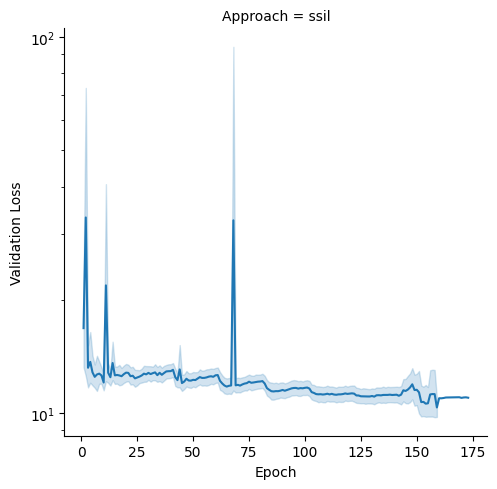

ewc


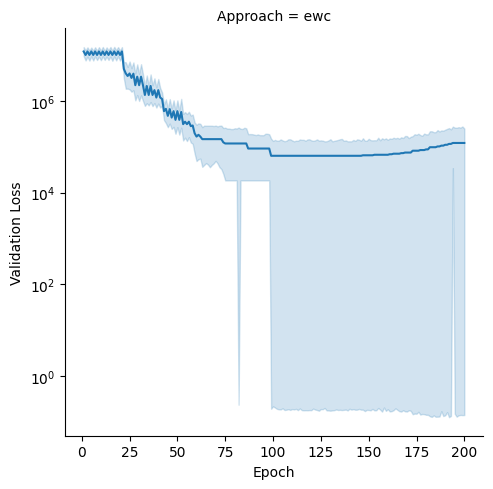

wu2022


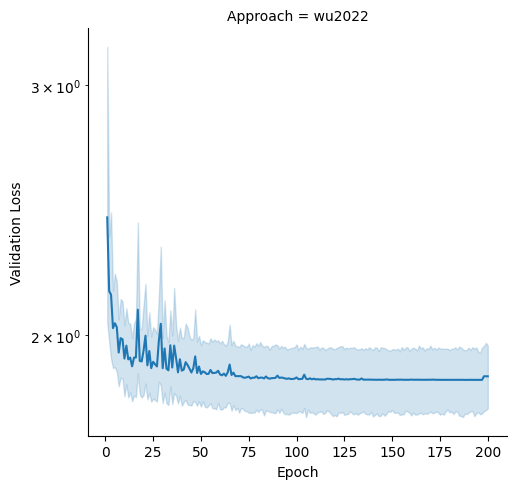

icarl


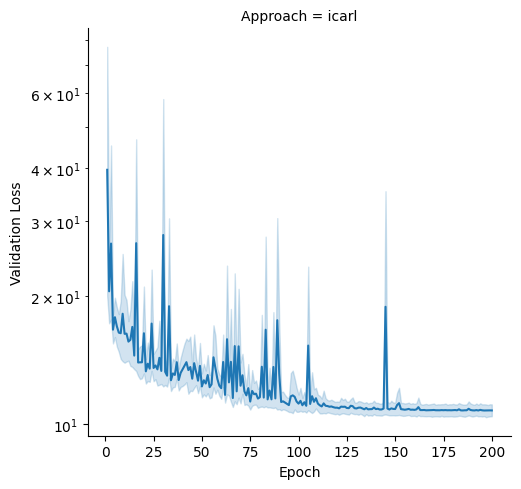

lucir


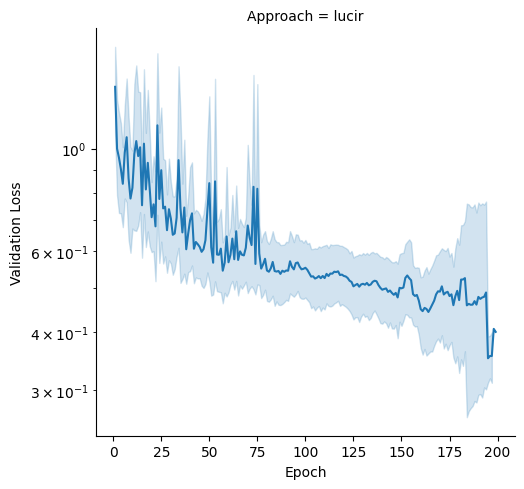

eeil


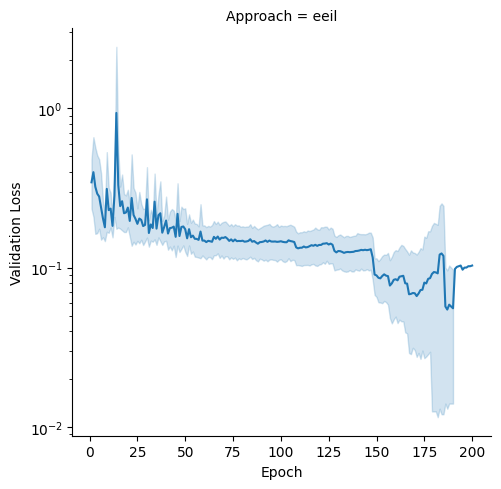

lwf


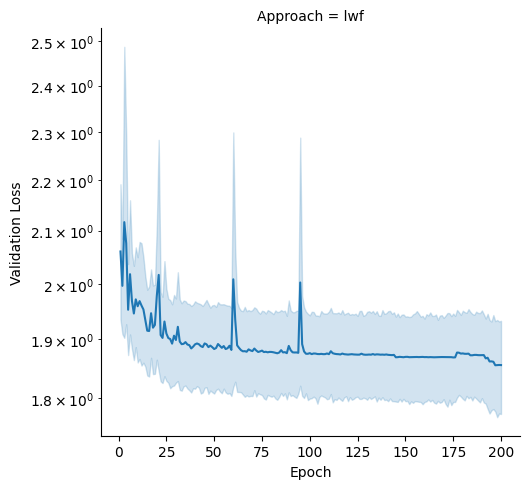

icarlp


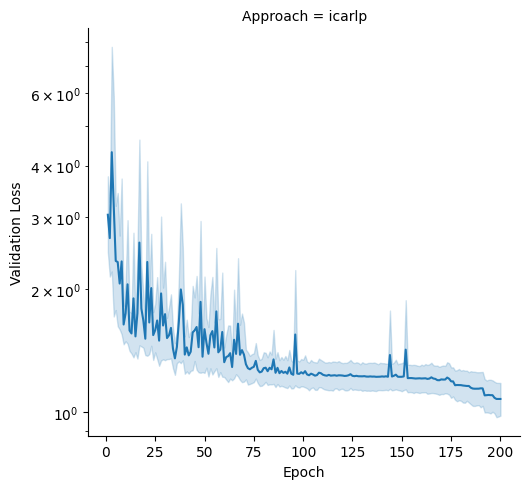

bic


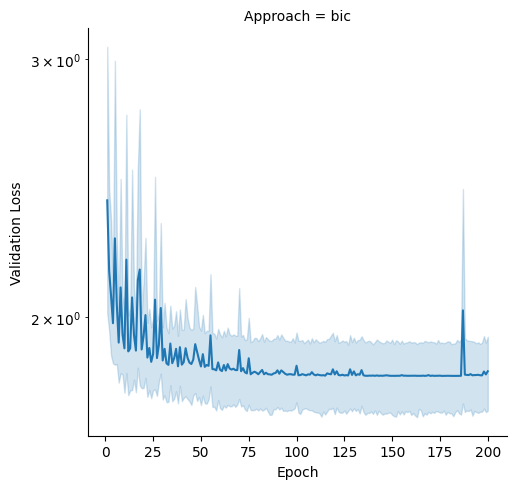

il2m


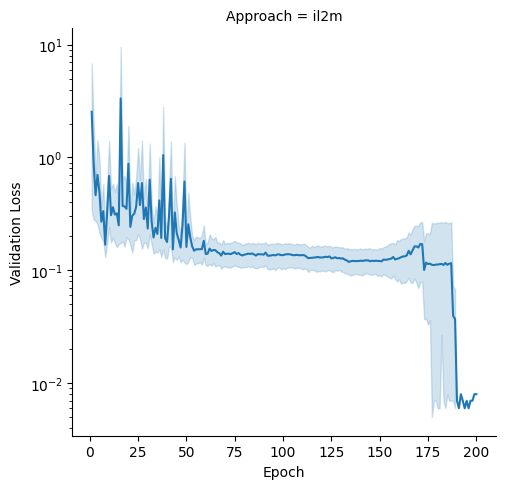

joint


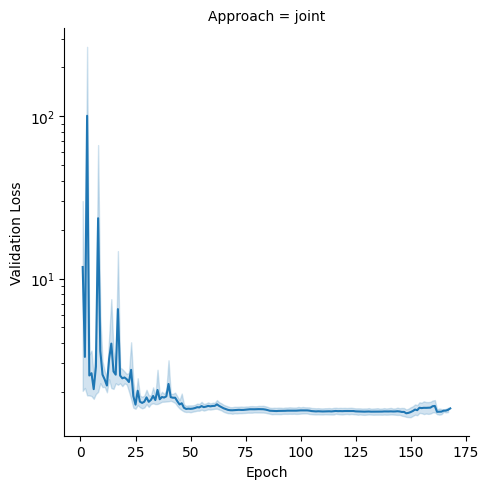

chen2021


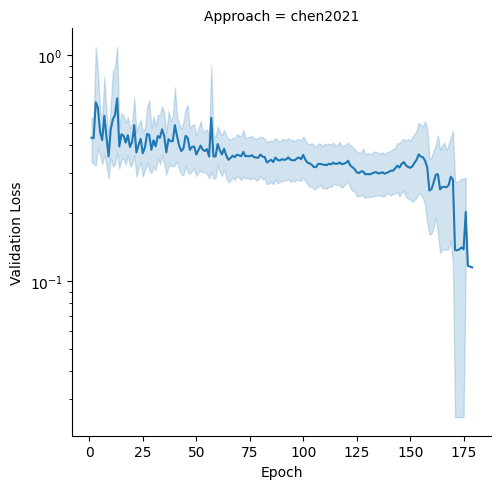

jointft


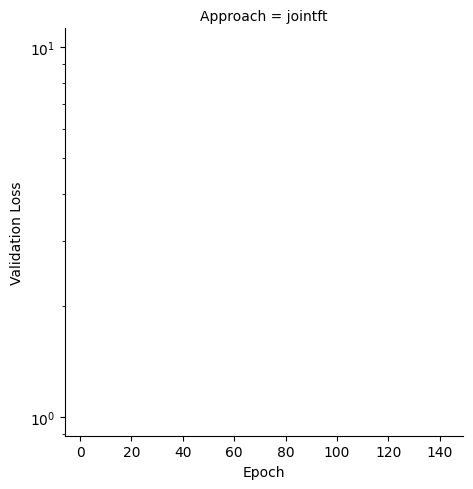

finetuning


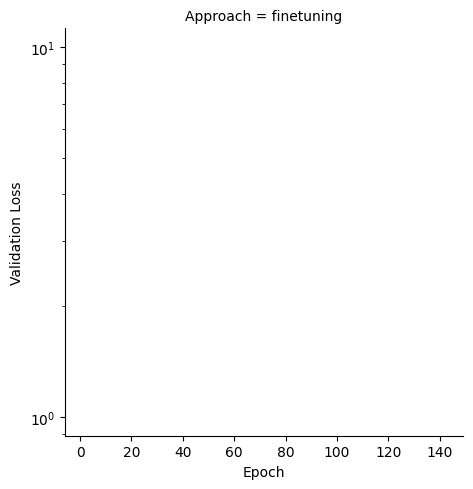

freezing


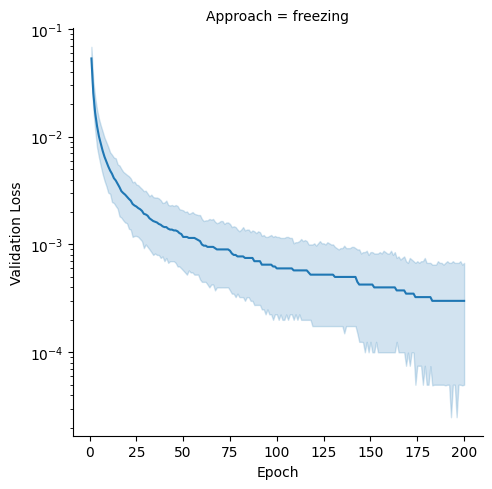

backbonefreezing


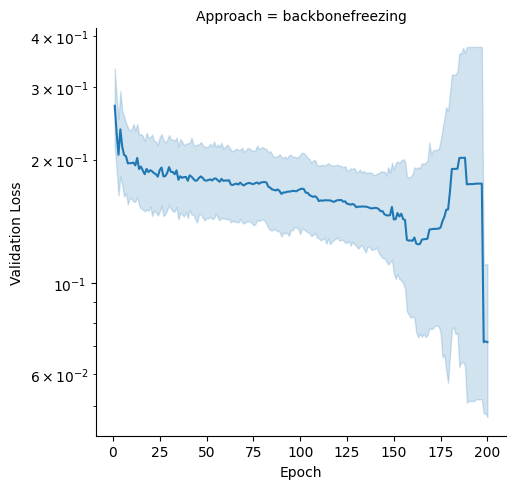

In [63]:
for approach in df_tr['Approach'].unique():
    print(approach)
    g = sns.relplot(
        data=df_tr[
            (df_tr['Approach'].isin([approach]))
            &
            (df_tr['Task'] == 1)
    #         &
    #         (~df_tr['Seed'].isin([4,24,26,35]))
    #         &
    #         (df_tr['Epoch'] > 175)
        ],
        x='Epoch', y='Validation Loss', col='Approach', kind='line',
        facet_kws={'sharey': False, 'sharex': True})
    g.set(yscale="log")
    plt.show()